Thành viên: </br>
* Trần Hoàng Anh (20521079)
* Phạm Tiến Dương (20521222)
* Nguyễn Huỳnh Vương Quốc (20521813)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, LSTM, SimpleRNN, Embedding, Input, Bidirectional, add, Embedding
from keras.models import Sequential, Model
import seaborn as sns

# Import

Dataset (https://www.kaggle.com/datasets/shayanfazeli/heartbeat)

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Code/DS312/dataset/mitbih_train.csv.zip")
test = pd.read_csv("/content/drive/MyDrive/Code/DS312/dataset/mitbih_test.csv.zip")

In [ ]:
abnormal = pd.read_csv("/content/drive/MyDrive/Code/DS312/dataset/ptbdb_abnormal.csv.zip")
normal = pd.read_csv("/content/drive/MyDrive/Code/DS312/dataset/ptbdb_normal.csv.zip")

In [ ]:
cols = [x for x in range(187)] + ["label"]
train.columns = cols
test.columns = cols
abnormal.columns = cols
normal.columns = cols

**---------------PLOT-----------------**

<Axes: xlabel='classes', ylabel='count'>

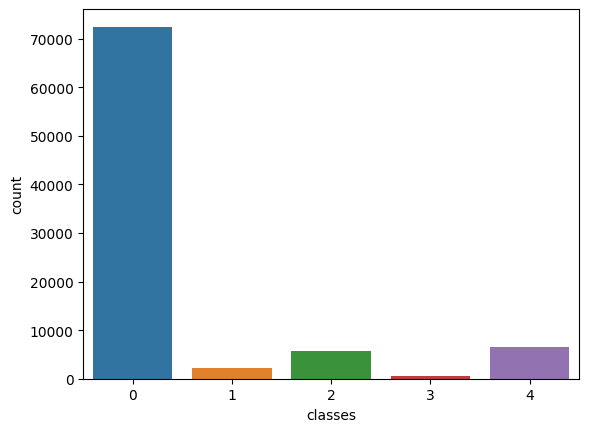

In [ ]:
x = np.array(train['label'].astype(int).value_counts().index)
y = np.array(train['label'].astype(int).value_counts())
df = pd.DataFrame(np.array([x,y]).T)
df.columns = ["classes", "count"]
sns.barplot(data = df, x = "classes", y = "count")

**Arrhythmia Dataset** </br>
* Number of Samples: 109446</br>
* Number of Categories: 5</br>
* Sampling Frequency: 125Hz</br>
* Data Source: Physionet's MIT-BIH Arrhythmia Dataset</br>
* Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

In [ ]:
train['label'].value_counts()

0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: label, dtype: int64

In [ ]:
test['label'].value_counts()

0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: label, dtype: int64

**The PTB Diagnostic ECG Database** </br>
* Number of Samples: 14552</br>
* Number of Categories: 2</br>
* Sampling Frequency: 125Hz</br>
* Data Source: Physionet's PTB Diagnostic Database

In [ ]:
print("0: {}, 1: {}".format(len(normal), len(abnormal)))

0: 4045, 1: 10505


<Axes: xlabel='classes', ylabel='count'>

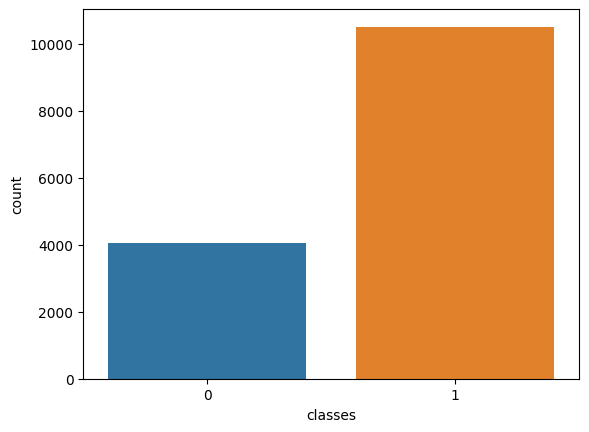

In [ ]:
df = pd.DataFrame([[0, len(normal)], [1, len(abnormal)]])
df.columns = ["classes", "count"]
sns.barplot(data = df, x = "classes", y = "count")

# Merge, shuffle and split

Merge datasets and change any label that is not 0 to 1

In [ ]:
concat_df = pd.concat([train, test, normal, abnormal])

In [ ]:
lab = concat_df['label'] > 0
lab = lab.astype(int)
concat_df['label'] = lab

**---------------PLOT-----------------**

<Axes: xlabel='classes', ylabel='count'>

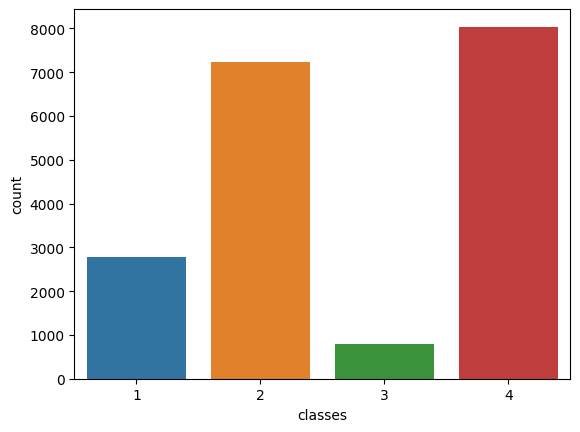

In [ ]:
x = np.array(concat_df['label'].astype(int).value_counts().index)
y = np.array(concat_df['label'].astype(int).value_counts())
df = pd.DataFrame(np.array([x,y]).T)
df.columns = ["classes", "count"]
sns.barplot(data = df, x = "classes", y = "count")

In [ ]:
concat_df['label'].value_counts()

0    94632
1    29362
Name: label, dtype: int64

Balance the 0 and 1 label

In [ ]:
normal_case = concat_df[concat_df['label'] == 0]
abnormal_case = concat_df[concat_df['label'] == 1]

In [ ]:
shuffle_normal = normal_case.sample(frac = 1).reset_index(drop = True).head(len(abnormal_case))

Aggregate the 0 and 1 to one set

In [ ]:
aggregate_df = pd.concat([shuffle_normal, abnormal_case]).sample(frac=1).reset_index()

<Axes: xlabel='classes', ylabel='count'>

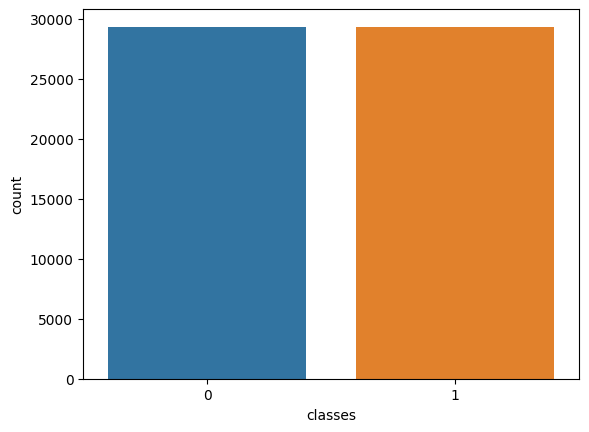

In [ ]:
x = np.array(aggregate_df['label'].astype(int).value_counts().index)
y = np.array(aggregate_df['label'].astype(int).value_counts())
df = pd.DataFrame(np.array([x,y]).T)
df.columns = ["classes", "count"]
sns.barplot(data = df, x = "classes", y = "count")

Split train test set

In [ ]:
cols = [x for x in range(187)]
# cols = cols.remove("label")

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(aggregate_df[cols], aggregate_df['label'], test_size = 0.2, random_state = 42)

In [ ]:
X_train = np.array(X_train).reshape(-1, 187, 1)
X_test = np.array(X_test).reshape(-1, 187, 1)
# X_train = np.array(X_train)
# X_test = np.array(X_test)

# Model

## MLP (ANN)

In [ ]:
import keras
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

optimizer=keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
def create_model_mlp():
    model = Sequential()
    model.add(Dense(256, input_shape=(187,)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=METRICS)

    return model

In [ ]:
model = create_model_mlp()

### Train

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [ ]:
hist = model.fit(X_train.reshape(-1, 187), y_train, batch_size=64, epochs=20, validation_split = 0.1, verbose = 1, callbacks = early_stopping)

Epoch 1/20
661/661 [==============================] - 2s 3ms/step - loss: 0.5117 - tp: 14090.0000 - fp: 4277.0000 - tn: 16839.0000 - fn: 7075.0000 - accuracy: 0.7315 - precision: 0.7671 - recall: 0.6657 - auc: 0.8221 - prc: 0.8380 - val_loss: 0.5161 - val_tp: 1464.0000 - val_fp: 407.0000 - val_tn: 1950.0000 - val_fn: 877.0000 - val_accuracy: 0.7267 - val_precision: 0.7825 - val_recall: 0.6254 - val_auc: 0.8163 - val_prc: 0.8352
Epoch 2/20
661/661 [==============================] - 2s 3ms/step - loss: 0.5111 - tp: 14118.0000 - fp: 4283.0000 - tn: 16833.0000 - fn: 7047.0000 - accuracy: 0.7320 - precision: 0.7672 - recall: 0.6670 - auc: 0.8224 - prc: 0.8382 - val_loss: 0.5432 - val_tp: 1865.0000 - val_fp: 794.0000 - val_tn: 1563.0000 - val_fn: 476.0000 - val_accuracy: 0.7297 - val_precision: 0.7014 - val_recall: 0.7967 - val_auc: 0.8184 - val_prc: 0.8311
Epoch 3/20
661/661 [==============================] - 2s 4ms/step - loss: 0.5116 - tp: 14139.0000 - fp: 4333.0000 - tn: 16783.0000 - fn:

### Evaluate

In [ ]:
y_pred = model.predict(X_test.reshape(-1, 187))

368/368 [==============================] - 1s 1ms/step


In [ ]:
def get_result(x):
  if x>0.5:
    return 1
  else:
    return 0

final = np.vectorize(get_result)
y_pred_fi = final(y_pred)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test), y_pred_fi))

              precision    recall  f1-score   support

           0       0.69      0.83      0.75      5889
           1       0.78      0.62      0.69      5856

    accuracy                           0.72     11745
   macro avg       0.73      0.72      0.72     11745
weighted avg       0.73      0.72      0.72     11745



## RNN

In [ ]:
import keras
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

optimizer=keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
def create_model_rnn():
    model = Sequential()
    model.add(SimpleRNN(256, input_shape=(187, 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=METRICS)

    return model

In [ ]:
model = create_model_rnn()

### Train

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [ ]:
hist = model.fit(X_train, y_train, batch_size=64, epochs=1, validation_split = 0.1, verbose = 1, callbacks = early_stopping)

661/661 [==============================] - 167s 250ms/step - loss: 0.7002 - tp: 10358.0000 - fp: 10346.0000 - tn: 13133.0000 - fn: 11634.0000 - accuracy: 0.5166 - precision: 0.5003 - recall: 0.4710 - auc: 0.5317 - prc: 0.5012 - val_loss: 0.6986 - val_tp: 2341.0000 - val_fp: 2357.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4983 - val_precision: 0.4983 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.4983


### Evaluate

In [ ]:
y_pred = model.predict(X_test)

368/368 [==============================] - 22s 59ms/step


In [ ]:
def get_result(x):
  if x>0.5:
    return 1
  else:
    return 0

final = np.vectorize(get_result)
y_pred_fi = final(y_pred)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test), y_pred_fi))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5889
           1       0.50      1.00      0.67      5856

    accuracy                           0.50     11745
   macro avg       0.25      0.50      0.33     11745
weighted avg       0.25      0.50      0.33     11745



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.DataFrame(y_train).value_counts()

label
0.0      23493
1.0       8400
dtype: int64

## Bidirectional LSTM
Ko xài

In [ ]:
import keras
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      # keras.metrics.BinaryAccuracy(name='accuracy'),
      # keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      # keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

optimizer=keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
def create_model_bilstm():
    input = Input(shape =(187,1))
    lstm1 = Bidirectional(LSTM(units=256, return_sequences=True,\
                       recurrent_dropout=0.2, dropout=0.2))(input)
    lstm1_side = Bidirectional(LSTM(units=256, return_sequences=False,\
                       recurrent_dropout=0.2, dropout=0.2))(input)
    dropout1 = Dropout(0.5)(lstm1)
    lstm2 = Bidirectional(LSTM(units=256, return_sequences=False,\
                       recurrent_dropout=0.2, dropout=0.2))(dropout1)
    dropout2 = Dropout(0.5)(lstm2)
    x = add([lstm1_side, lstm2])
    output = Dense(1, activation='sigmoid')(x)
    model = Model(input, output)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=METRICS)
    return model


In [ ]:
model = create_model_bilstm()

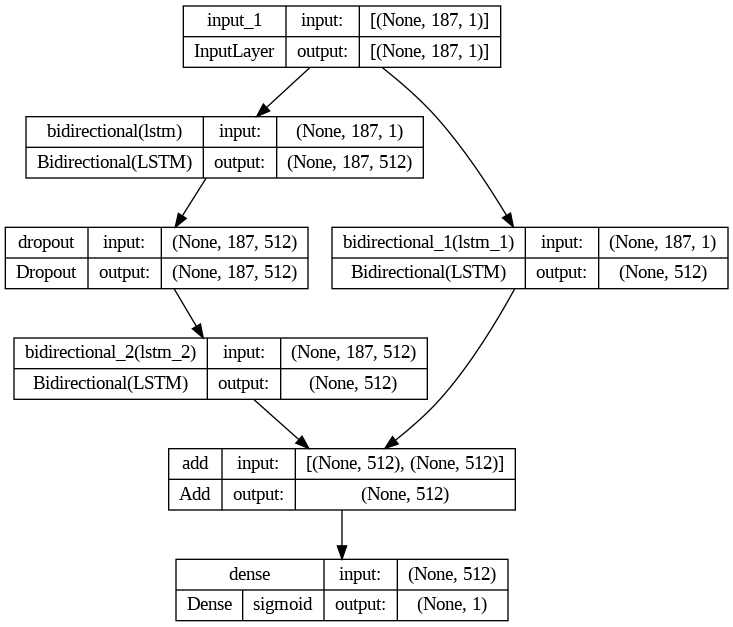

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes= True, show_layer_activations = True)

### Train

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [ ]:
hist = model.fit(X_train, y_train, batch_size=64, epochs=1, validation_split = 0.1, verbose = 1, callbacks = early_stopping)

449/449 [==============================] - ETA: 0s - loss: 0.5583 - tp: 778.0000 - fp: 418.0000 - tn: 20656.0000 - fn: 6851.0000 - recall: 0.1020 - auc: 0.6041 

449/449 [==============================] - 6524s 14s/step - loss: 0.5583 - tp: 778.0000 - fp: 418.0000 - tn: 20656.0000 - fn: 6851.0000 - recall: 0.1020 - auc: 0.6041 - val_loss: 0.5293 - val_tp: 102.0000 - val_fp: 41.0000 - val_tn: 2327.0000 - val_fn: 720.0000 - val_recall: 0.1241 - val_auc: 0.6630


In [ ]:
model.save("/content/drive/MyDrive/Code/DS312/model/bilstm_multimetric_epoch1.h5")

### Evaluate

In [ ]:
y_pred = model.predict(X_test)

250/250 [==============================] - 452s 2s/step


In [ ]:
def get_result(x):
  if x>0.5:
    return 1
  else:
    return 0

final = np.vectorize(get_result)
y_pred_fi = final(y_pred)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test), y_pred_fi))

              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      5889
         1.0       0.94      0.05      0.09      2085

    accuracy                           0.75      7974
   macro avg       0.84      0.52      0.48      7974
weighted avg       0.80      0.75      0.66      7974



## LSTM

In [ ]:
import keras
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

optimizer=keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
def create_model_lstm():
    # input = Input(shape =(187,1))
    # lstm1 = LSTM(units=256, return_sequences=True,\
    #                    recurrent_dropout=0.2, dropout=0.2)(input)
    # dropout1 = Dropout(0.5)(lstm1)
    # lstm2 = LSTM(units=256, return_sequences=False,\
    #                    recurrent_dropout=0.2, dropout=0.2)(dropout1)
    # dropout2 = Dropout(0.5)(lstm2)
    # output = Dense(1, activation='sigmoid')(dropout2)
    # model = Model(input, output)
    # model.compile(loss='binary_crossentropy',
    #               optimizer=optimizer,
    #               metrics=METRICS)

    model = Sequential()
    model.add(LSTM(64, input_shape=(187, 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=METRICS)

    return model


In [ ]:
model = create_model_lstm()

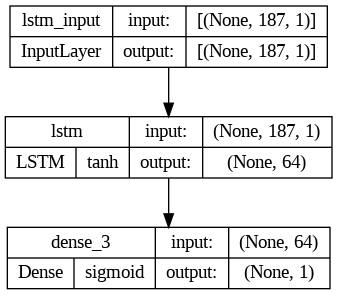

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes= True, show_layer_activations = True)

### Train

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [ ]:
hist = model.fit(X_train, y_train, batch_size=64, epochs=3, validation_split = 0.1, verbose = 1, callbacks = early_stopping)

Epoch 1/3
661/661 [==============================] - 92s 132ms/step - loss: 0.6907 - tp: 9667.0000 - fp: 9398.0000 - tn: 11718.0000 - fn: 11498.0000 - accuracy: 0.5058 - precision: 0.5071 - recall: 0.4567 - auc: 0.5120 - prc: 0.5257 - val_loss: 0.6919 - val_tp: 126.0000 - val_fp: 87.0000 - val_tn: 2270.0000 - val_fn: 2215.0000 - val_accuracy: 0.5100 - val_precision: 0.5915 - val_recall: 0.0538 - val_auc: 0.5079 - val_prc: 0.5210
Epoch 2/3
661/661 [==============================] - 84s 127ms/step - loss: 0.6898 - tp: 7378.0000 - fp: 7007.0000 - tn: 14109.0000 - fn: 13787.0000 - accuracy: 0.5082 - precision: 0.5129 - recall: 0.3486 - auc: 0.5135 - prc: 0.5289 - val_loss: 0.6929 - val_tp: 2328.0000 - val_fp: 2318.0000 - val_tn: 39.0000 - val_fn: 13.0000 - val_accuracy: 0.5038 - val_precision: 0.5011 - val_recall: 0.9944 - val_auc: 0.5213 - val_prc: 0.5308
Epoch 3/3
661/661 [==============================] - 87s 131ms/step - loss: 0.6894 - tp: 6806.0000 - fp: 6416.0000 - tn: 14700.0000 - f

In [ ]:
model.save("/content/drive/MyDrive/Code/DS312/model/lstm_multimetric_epoch1.h5")

### Evaluate

In [ ]:
y_pred = model.predict(X_test)

368/368 [==============================] - 12s 30ms/step


In [ ]:
def get_result(x):
  if x>0.5:
    return 1
  else:
    return 0

final = np.vectorize(get_result)
y_pred_fi = final(y_pred)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test), y_pred_fi))

              precision    recall  f1-score   support

           0       0.51      0.98      0.67      5889
           1       0.73      0.05      0.09      5856

    accuracy                           0.52     11745
   macro avg       0.62      0.52      0.38     11745
weighted avg       0.62      0.52      0.38     11745



## Decision Tree

In [ ]:
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train.reshape(-1, 187), y_train)

y_pred_tree = decision_tree.predict(X_test.reshape(-1, 187))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test), y_pred_tree))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      5889
           1       0.89      0.89      0.89      5856

    accuracy                           0.89     11745
   macro avg       0.89      0.89      0.89     11745
weighted avg       0.89      0.89      0.89     11745



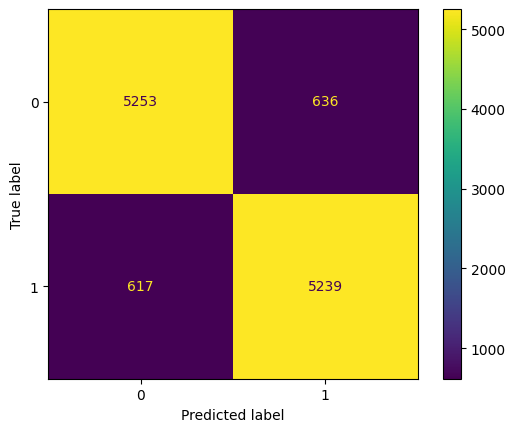

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(np.array(y_test), y_pred_tree, labels = decision_tree.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=decision_tree.classes_)
disp.plot()

plt.show()

## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=150, random_state=0)
forest.fit(X_train.reshape(-1, 187), y_train)
y_pred = forest.predict(X_test.reshape(-1, 187))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      5889
           1       0.96      0.95      0.96      5856

    accuracy                           0.96     11745
   macro avg       0.96      0.96      0.96     11745
weighted avg       0.96      0.96      0.96     11745



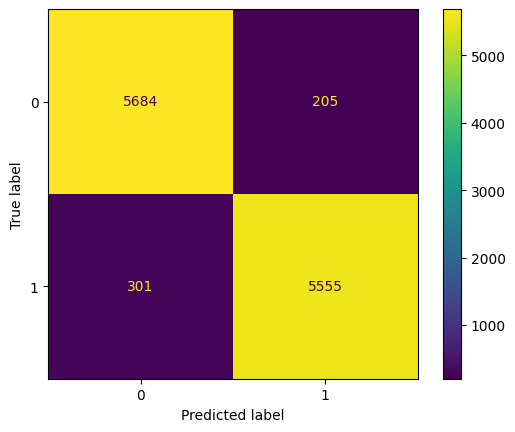

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(np.array(y_test), y_pred, labels = forest.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=forest.classes_)
disp.plot()

plt.show()

## LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', verbose = True)

clf.fit(X_train.reshape(-1, 187), y_train)

y_pred = clf.predict(X_test.reshape(-1, 187))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      5889
           1       0.75      0.68      0.72      5856

    accuracy                           0.73     11745
   macro avg       0.73      0.73      0.73     11745
weighted avg       0.73      0.73      0.73     11745



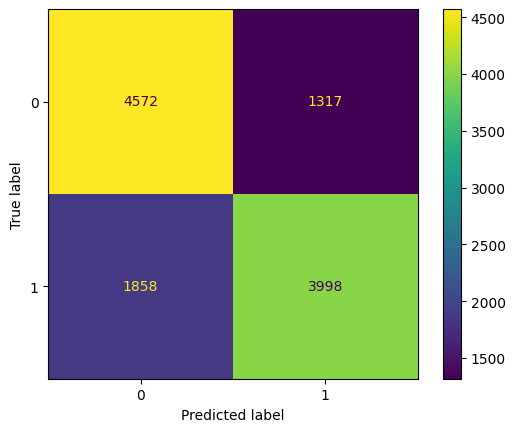

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(np.array(y_test), y_pred, labels = clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

plt.show()

## SVM

In [ ]:
from sklearn import svm

svm_model = svm.SVC(kernel='linear', verbose=True) # Linear Kernel

svm_model.fit(X_train.reshape(-1, 187), y_train)

y_pred = svm_model.predict(X_test.reshape(-1, 187))

[LibSVM]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.71      0.82      0.76      5889
           1       0.79      0.66      0.72      5856

    accuracy                           0.74     11745
   macro avg       0.75      0.74      0.74     11745
weighted avg       0.75      0.74      0.74     11745



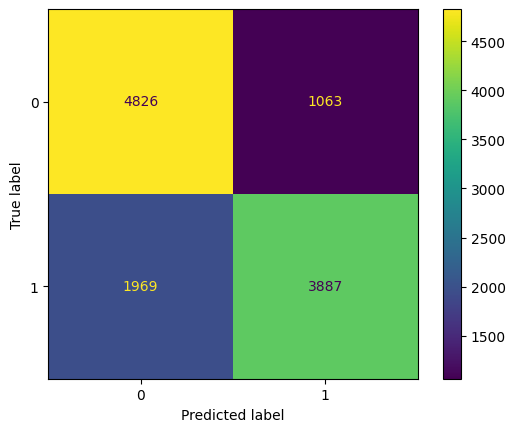

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(np.array(y_test), y_pred, labels = svm_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svm_model.classes_)
disp.plot()

plt.show()

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train.reshape(-1, 187), y_train)

y_pred = neigh.predict(X_test.reshape(-1, 187))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      5889
           1       0.96      0.93      0.94      5856

    accuracy                           0.95     11745
   macro avg       0.95      0.95      0.95     11745
weighted avg       0.95      0.95      0.95     11745



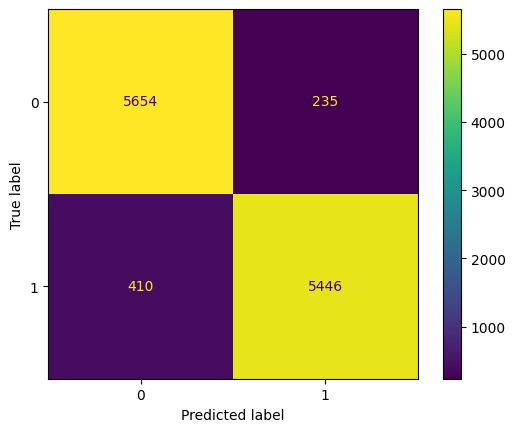

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(np.array(y_test), y_pred, labels = neigh.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=neigh.classes_)
disp.plot()

plt.show()

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
naive = MultinomialNB(force_alpha=True)
naive.fit(X_train.reshape(-1, 187), y_train)

y_pred = naive.predict(X_test.reshape(-1, 187))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.66      0.70      0.68      5889
           1       0.68      0.64      0.66      5856

    accuracy                           0.67     11745
   macro avg       0.67      0.67      0.67     11745
weighted avg       0.67      0.67      0.67     11745



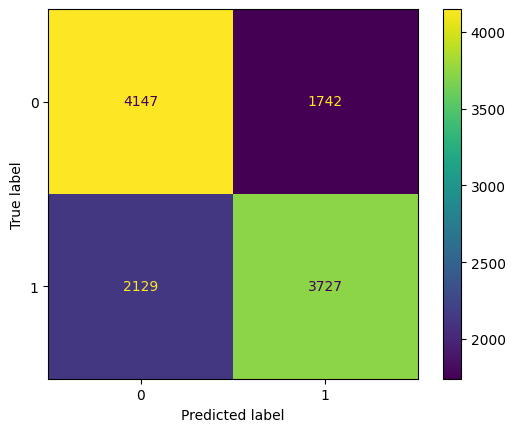

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(np.array(y_test), y_pred, labels = naive.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=naive.classes_)
disp.plot()

plt.show()

# Model for Arrhythmia

## Preprocess

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Code/DS312/dataset/mitbih_train.csv.zip")
test = pd.read_csv("/content/drive/MyDrive/Code/DS312/dataset/mitbih_test.csv.zip")

In [ ]:
cols = [x for x in range(187)] + ["label"]
train.columns = cols
test.columns = cols

In [ ]:
concat_df = pd.concat([train, test])

In [ ]:
concat_df = concat_df[concat_df['label'] > 0]
# lab = lab.astype(int)
concat_df['label'] = concat_df['label'].astype(int)
# concat_df['label'] = concat_df['label'] - 1
concat_df.sample(frac=1).reset_index(inplace = True)

In [ ]:
classes = list(concat_df['label'].value_counts().index)
count_classes = list(concat_df['label'].value_counts())
concat_df['label'].value_counts()

4    8039
2    7236
1    2779
3     803
Name: label, dtype: int64

In [ ]:
class_weight = {}
for i in range(len(classes)):
  class_weight.update({classes[i]: (1/ count_classes[i]) * (len(concat_df) / len(classes))})

myKeys = list(class_weight.keys())
myKeys.sort()
class_weight = {i: class_weight[i] for i in myKeys}

In [ ]:
class_weight

{1: 1.696383591219863,
 2: 0.6514994472084024,
 3: 5.87079701120797,
 4: 0.5864224406020649}

In [ ]:
# cols = [x for x in range(187)]
# X = concat_df[cols]
# y = pd.get_dummies(concat_df['label'])

Split

In [ ]:
from sklearn.model_selection import train_test_split
cols = [x for x in range(187)]

X_train2, X_test2, y_train2, y_test2 = train_test_split(concat_df[cols], concat_df['label'], test_size = 0.2, random_state = 42)

In [ ]:
X_train2 = np.array(X_train2).reshape(-1, 187, 1)
X_test2 = np.array(X_test2).reshape(-1, 187, 1)
# X_train = np.array(X_train)
# X_test = np.array(X_test)

## MLP (ANN)

In [ ]:
import keras
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.Accuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

optimizer=keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
def create_model_mlp():

    model = Sequential()
    model.add(Dense(256, input_shape=(187,)))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

    return model


In [ ]:
model = create_model_lstm()

### Train

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [ ]:
hist = model.fit(X_train2.reshape(-1, 187), np.array(pd.get_dummies(y_train2)), batch_size=64, epochs=20, validation_split = 0.1, verbose = 1, callbacks = early_stopping)

### Evaluate

In [ ]:
y_pred = model.predict(X_test2.reshape(-1, 187))
y_pred = [np.argmax(y_pred[x]) for x in range(len(X_test2))]
y_pred = np.array(y_pred) + 1

118/118 [==============================] - 1s 7ms/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test2), y_pred))

              precision    recall  f1-score   support

           1       0.92      0.82      0.87       536
           2       0.88      0.94      0.91      1436
           3       0.75      0.80      0.78       178
           4       0.96      0.94      0.95      1622

    accuracy                           0.91      3772
   macro avg       0.88      0.87      0.88      3772
weighted avg       0.92      0.91      0.91      3772



## LSTM

In [ ]:
import keras
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.Accuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

optimizer=keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
def create_model_lstm():

    model = Sequential()
    model.add(LSTM(256, input_shape=(187, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

    return model


In [ ]:
model = create_model_lstm()

### Train

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [ ]:
hist = model.fit(X_train2, np.array(pd.get_dummies(y_train2)), batch_size=64, epochs=2, validation_split = 0.1, verbose = 1, callbacks = early_stopping)

Epoch 1/2
213/213 [==============================] - ETA: 0s - loss: 1.1179 - accuracy: 0.4599

213/213 [==============================] - 194s 908ms/step - loss: 1.1179 - accuracy: 0.4599 - val_loss: 1.1440 - val_accuracy: 0.4460
Epoch 2/2
213/213 [==============================] - ETA: 0s - loss: 1.1020 - accuracy: 0.4713

213/213 [==============================] - 185s 867ms/step - loss: 1.1020 - accuracy: 0.4713 - val_loss: 1.0460 - val_accuracy: 0.5414


### Evaluate

In [ ]:
y_pred = model.predict(X_test2)
y_pred = [np.argmax(y_pred[x]) for x in range(len(X_test2))]
y_pred = np.array(y_pred) + 1

118/118 [==============================] - 25s 201ms/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test2), y_pred))

              precision    recall  f1-score   support

           1       0.78      0.11      0.19       536
           2       0.81      0.28      0.42      1436
           3       0.00      0.00      0.00       178
           4       0.51      1.00      0.67      1622

    accuracy                           0.55      3772
   macro avg       0.52      0.35      0.32      3772
weighted avg       0.64      0.55      0.47      3772



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Tree

In [ ]:
from sklearn import tree

decision_tree2 = tree.DecisionTreeClassifier()
decision_tree2 = decision_tree2.fit(X_train2.reshape(-1, 187), y_train2)

y_pred = decision_tree2.predict(X_test2.reshape(-1, 187))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test2), y_pred))

              precision    recall  f1-score   support

           1       0.90      0.90      0.90       536
           2       0.94      0.94      0.94      1436
           3       0.78      0.74      0.76       178
           4       0.97      0.97      0.97      1622

    accuracy                           0.94      3772
   macro avg       0.90      0.89      0.89      3772
weighted avg       0.94      0.94      0.94      3772



## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest2 = RandomForestClassifier(n_estimators=150, random_state=0)
forest2.fit(X_train2.reshape(-1, 187), y_train2)
y_pred = forest2.predict(X_test2.reshape(-1, 187))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test2), y_pred, digits = 5))

              precision    recall  f1-score   support

           1    0.97148   0.95336   0.96234       536
           2    0.96246   0.98189   0.97208      1436
           3    0.91720   0.80899   0.85970       178
           4    0.98892   0.99014   0.98953      1622

    accuracy                        0.97322      3772
   macro avg    0.96001   0.93359   0.94591      3772
weighted avg    0.97298   0.97322   0.97289      3772



In [ ]:
y_pred = forest.predict(np.array(test[cols]).reshape(-1, 187))

for i in range(len(y_pred > 0)):
  if y_pred[i] == True:
    y_pred[i] = int(forest2.predict([np.array(test[cols]).reshape(-1, 187)[i]]))

from sklearn.metrics import classification_report

print(classification_report(np.array(test["label"]), y_pred, digits = 5))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     18117
         1.0       0.78      0.94      0.86       556
         2.0       0.88      0.99      0.94      1448
         3.0       0.90      0.95      0.92       162
         4.0       0.96      1.00      0.97      1608

    accuracy                           0.98     21891
   macro avg       0.90      0.97      0.94     21891
weighted avg       0.98      0.98      0.98     21891



## LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

clf2 = LogisticRegression(solver='lbfgs', verbose = True)

clf2.fit(X_train2.reshape(-1, 187), y_train2)

y_pred = clf2.predict(X_test2.reshape(-1, 187))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test2), y_pred, digits = 5))

              precision    recall  f1-score   support

           1    0.92017   0.81716   0.86561       536
           2    0.88134   0.93106   0.90552      1436
           3    0.77528   0.77528   0.77528       178
           4    0.95690   0.94451   0.95067      1622

    accuracy                        0.91331      3772
   macro avg    0.88342   0.86700   0.87427      3772
weighted avg    0.91435   0.91331   0.91312      3772



## SVM

In [ ]:
from sklearn import svm

svm_model2 = svm.SVC(kernel='linear', verbose=True) # Linear Kernel

svm_model2.fit(X_train2.reshape(-1, 187), y_train2)

y_pred = svm_model2.predict(X_test2.reshape(-1, 187))

[LibSVM]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test2), y_pred, digits = 5))

              precision    recall  f1-score   support

           1    0.91667   0.84142   0.87743       536
           2    0.88766   0.94638   0.91608      1436
           3    0.79558   0.80899   0.80223       178
           4    0.97130   0.93896   0.95486      1622

    accuracy                        0.92179      3772
   macro avg    0.89280   0.88394   0.88765      3772
weighted avg    0.92340   0.92179   0.92189      3772



## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh2 = KNeighborsClassifier(n_neighbors=3)
neigh2.fit(X_train2.reshape(-1, 187), y_train2)

y_pred = neigh2.predict(X_test2.reshape(-1, 187))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test2), y_pred, digits = 5))

              precision    recall  f1-score   support

           1    0.95029   0.92724   0.93862       536
           2    0.95616   0.97214   0.96409      1436
           3    0.87425   0.82022   0.84638       178
           4    0.98705   0.98705   0.98705      1622

    accuracy                        0.96501      3772
   macro avg    0.94194   0.92667   0.93403      3772
weighted avg    0.96475   0.96501   0.96479      3772



## Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
naive2 = MultinomialNB(force_alpha=True)
naive2.fit(X_train2.reshape(-1, 187), y_train2)

y_pred = naive2.predict(X_test2.reshape(-1, 187))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_test2), y_pred, digits = 5))

              precision    recall  f1-score   support

           1    0.56213   0.17724   0.26950       536
           2    0.79890   0.30432   0.44075      1436
           3    0.29529   0.91573   0.44658       178
           4    0.63139   0.97472   0.76636      1622

    accuracy                        0.60339      3772
   macro avg    0.57193   0.59300   0.48080      3772
weighted avg    0.66946   0.60339   0.55671      3772



# Framework and Comparision

Model 1: KNN, Decision Tree, Random Forest </br>
Model 2: KNN, Decision Tree, Random Forest

## Pairs

In [ ]:
from sklearn.metrics import classification_report

### KNN

#### KNN -> KNN

In [ ]:
y_pred_model1 = neigh.predict(np.array(test[cols]).reshape(-1, 187))
y_pred_model2 = neigh2.predict(np.array(test[cols]).reshape(-1, 187))
mask1 = y_pred_model1 > 0
y_pred_final = (y_pred_model1 * (1 - mask1)) + (y_pred_model2 * mask1)
print(classification_report(np.array(test["label"]), y_pred_final, digits = 5))

              precision    recall  f1-score   support

         0.0    0.99092   0.97025   0.98048     18117
         1.0    0.64173   0.80216   0.71303       556
         2.0    0.85521   0.95856   0.90394      1448
         3.0    0.70109   0.79630   0.74566       162
         4.0    0.95091   0.97575   0.96317      1608

    accuracy                        0.96432     21891
   macro avg    0.82797   0.90060   0.86126     21891
weighted avg    0.96799   0.96432   0.96561     21891



#### KNN -> Decision Tree

In [ ]:
y_pred_model1 = neigh.predict(np.array(test[cols]).reshape(-1, 187))
y_pred_model2 = decision_tree2.predict(np.array(test[cols]).reshape(-1, 187))
mask1 = y_pred_model1 > 0
y_pred_final = (y_pred_model1 * (1 - mask1)) + (y_pred_model2 * mask1)
print(classification_report(np.array(test["label"]), y_pred_final, digits = 5))

              precision    recall  f1-score   support

         0.0    0.99155   0.97185   0.98160     18117
         1.0    0.64082   0.84712   0.72967       556
         2.0    0.89467   0.96202   0.92712      1448
         3.0    0.73958   0.87654   0.80226       162
         4.0    0.95636   0.98134   0.96869      1608

    accuracy                        0.96802     21891
   macro avg    0.84460   0.92778   0.88187     21891
weighted avg    0.97179   0.96802   0.96932     21891



#### KNN -> Random Forest

In [ ]:
y_pred_model1 = neigh.predict(np.array(test[cols]).reshape(-1, 187))
y_pred_model2 = forest2.predict(np.array(test[cols]).reshape(-1, 187))
mask1 = y_pred_model1 > 0
y_pred_final = (y_pred_model1 * (1 - mask1)) + (y_pred_model2 * mask1)
print(classification_report(np.array(test["label"]), y_pred_final, digits = 5))

              precision    recall  f1-score   support

         0.0    0.99092   0.97025   0.98048     18117
         1.0    0.62735   0.84173   0.71889       556
         2.0    0.88062   0.97307   0.92454      1448
         3.0    0.88889   0.88889   0.88889       162
         4.0    0.96107   0.98259   0.97171      1608

    accuracy                        0.96748     21891
   macro avg    0.86977   0.93130   0.89690     21891
weighted avg    0.97145   0.96748   0.96881     21891



### Decision Tree

#### Decision Tree -> KNN

In [ ]:
y_pred_model1 = decision_tree.predict(np.array(test[cols]).reshape(-1, 187))
y_pred_model2 = neigh2.predict(np.array(test[cols]).reshape(-1, 187))
mask1 = y_pred_model1 > 0
y_pred_final = (y_pred_model1 * (1 - mask1)) + (y_pred_model2 * mask1)
print(classification_report(np.array(test["label"]), y_pred_final, digits = 5))

              precision    recall  f1-score   support

         0.0    0.99577   0.92162   0.95726     18117
         1.0    0.41206   0.88489   0.56229       556
         2.0    0.75148   0.96478   0.84487      1448
         3.0    0.44408   0.83333   0.57940       162
         4.0    0.89468   0.98259   0.93657      1608

    accuracy                        0.92737     21891
   macro avg    0.69961   0.91744   0.77608     21891
weighted avg    0.95327   0.92737   0.93548     21891



#### Decision Tree -> Decision Tree

In [ ]:
y_pred_model1 = decision_tree.predict(np.array(test[cols]).reshape(-1, 187))
y_pred_model2 = decision_tree2.predict(np.array(test[cols]).reshape(-1, 187))
mask1 = y_pred_model1 > 0
y_pred_final = (y_pred_model1 * (1 - mask1)) + (y_pred_model2 * mask1)
print(classification_report(np.array(test["label"]), y_pred_final, digits = 5))

              precision    recall  f1-score   support

         0.0    0.99577   0.92162   0.95726     18117
         1.0    0.41390   0.92086   0.57111       556
         2.0    0.78341   0.97169   0.86745      1448
         3.0    0.47937   0.93210   0.63312       162
         4.0    0.89465   0.98756   0.93881      1608

    accuracy                        0.92983     21891
   macro avg    0.71342   0.94677   0.79355     21891
weighted avg    0.95569   0.92983   0.93776     21891



#### Decision Tree -> Random Forest

In [ ]:
y_pred_model1 = decision_tree.predict(np.array(test[cols]).reshape(-1, 187))
y_pred_model2 = forest2.predict(np.array(test[cols]).reshape(-1, 187))
mask1 = y_pred_model1 > 0
y_pred_final = (y_pred_model1 * (1 - mask1)) + (y_pred_model2 * mask1)
print(classification_report(np.array(test["label"]), y_pred_final, digits = 5))

              precision    recall  f1-score   support

         0.0    0.99577   0.92162   0.95726     18117
         1.0    0.41687   0.93345   0.57635       556
         2.0    0.75106   0.98135   0.85090      1448
         3.0    0.61538   0.93827   0.74328       162
         4.0    0.91547   0.99005   0.95130      1608

    accuracy                        0.93102     21891
   macro avg    0.73891   0.95295   0.81582     21891
weighted avg    0.95616   0.93102   0.93853     21891



### Random Forest

#### Random Forest -> KNN

In [ ]:
y_pred_model1 = forest.predict(np.array(test[cols]).reshape(-1, 187))
y_pred_model2 = neigh2.predict(np.array(test[cols]).reshape(-1, 187))
mask1 = y_pred_model1 > 0
y_pred_final = (y_pred_model1 * (1 - mask1)) + (y_pred_model2 * mask1)
print(classification_report(np.array(test["label"]), y_pred_final, digits = 5))

              precision    recall  f1-score   support

         0.0    0.99769   0.97765   0.98757     18117
         1.0    0.73560   0.89568   0.80779       556
         2.0    0.87330   0.97583   0.92172      1448
         3.0    0.78286   0.84568   0.81306       162
         4.0    0.95144   0.98694   0.96886      1608

    accuracy                        0.97515     21891
   macro avg    0.86818   0.93636   0.89980     21891
weighted avg    0.97782   0.97515   0.97598     21891



#### Random Forest -> Decision Tree

In [ ]:
y_pred_model1 = forest.predict(np.array(test[cols]).reshape(-1, 187))
y_pred_model2 = decision_tree2.predict(np.array(test[cols]).reshape(-1, 187))
mask1 = y_pred_model1 > 0
y_pred_final = (y_pred_model1 * (1 - mask1)) + (y_pred_model2 * mask1)
print(classification_report(np.array(test["label"]), y_pred_final, digits = 5))

              precision    recall  f1-score   support

         0.0    0.99769   0.97765   0.98757     18117
         1.0    0.75918   0.92986   0.83589       556
         2.0    0.90683   0.98135   0.94262      1448
         3.0    0.79275   0.94444   0.86197       162
         4.0    0.93989   0.99192   0.96520      1608

    accuracy                        0.97748     21891
   macro avg    0.87927   0.96504   0.91865     21891
weighted avg    0.97986   0.97748   0.97817     21891



#### Random Forest -> Random Forest

In [ ]:
y_pred_model1 = forest.predict(np.array(test[cols]).reshape(-1, 187))
y_pred_model2 = forest2.predict(np.array(test[cols]).reshape(-1, 187))
mask1 = y_pred_model1 > 0
y_pred_final = (y_pred_model1 * (1 - mask1)) + (y_pred_model2 * mask1)
print(classification_report(np.array(test["label"]), y_pred_final, digits = 5))

              precision    recall  f1-score   support

         0.0    0.99769   0.97765   0.98757     18117
         1.0    0.78326   0.94245   0.85551       556
         2.0    0.88478   0.99171   0.93520      1448
         3.0    0.90058   0.95062   0.92492       162
         4.0    0.95522   0.99502   0.97472      1608

    accuracy                        0.97876     21891
   macro avg    0.90431   0.97149   0.93558     21891
weighted avg    0.98094   0.97876   0.97934     21891



## Base-line model

### Random Forest

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

forest2_normal = RandomForestClassifier(n_estimators=150, random_state=0)
forest2_normal.fit(np.array(train[cols]).reshape(-1, 187), np.array(train["label"]))
y_pred = forest2_normal.predict(np.array(test[cols]).reshape(-1, 187))
print(classification_report(np.array(test["label"]), y_pred, digits = 5))

              precision    recall  f1-score   support

         0.0    0.97275   0.99901   0.98570     18117
         1.0    0.98240   0.60252   0.74693       556
         2.0    0.97858   0.88329   0.92849      1448
         3.0    0.87719   0.61728   0.72464       162
         4.0    0.99540   0.94279   0.96838      1608

    accuracy                        0.97433     21891
   macro avg    0.96127   0.80898   0.87083     21891
weighted avg    0.97434   0.97433   0.97265     21891



### KNN

In [ ]:
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

neigh_normal = KNeighborsClassifier(n_neighbors=3)
neigh_normal.fit(np.array(train[cols]).reshape(-1, 187), np.array(train["label"]))
y_pred = neigh_normal.predict(np.array(test[cols]).reshape(-1, 187))
print(classification_report(np.array(test["label"]), y_pred, digits = 5))

              precision    recall  f1-score   support

         0.0    0.98063   0.99481   0.98767     18117
         1.0    0.88837   0.68705   0.77485       556
         2.0    0.94809   0.90815   0.92769      1448
         3.0    0.78723   0.68519   0.73267       162
         4.0    0.99356   0.96020   0.97660      1608

    accuracy                        0.97643     21891
   macro avg    0.91958   0.84708   0.87990     21891
weighted avg    0.97565   0.97643   0.97560     21891



### Decision Tree

In [ ]:
from sklearn.metrics import classification_report
from sklearn import tree

decision_tree_normal = tree.DecisionTreeClassifier()
decision_tree_normal.fit(np.array(train[cols]).reshape(-1, 187), np.array(train["label"]))
y_pred = decision_tree_normal.predict(np.array(test[cols]).reshape(-1, 187))
print(classification_report(np.array(test["label"]), y_pred, digits = 5))

              precision    recall  f1-score   support

         0.0    0.97522   0.97527   0.97524     18117
         1.0    0.64663   0.63849   0.64253       556
         2.0    0.85872   0.86050   0.85961      1448
         3.0    0.54237   0.59259   0.56637       162
         4.0    0.94110   0.93408   0.93758      1608

    accuracy                        0.95327     21891
   macro avg    0.79281   0.80019   0.79627     21891
weighted avg    0.95346   0.95327   0.95335     21891

